
# Análise Inicial — Produção Industrial Brasileira


Este notebook apresenta uma análise exploratória inicial com base em dados sintéticos simulando indicadores industriais no Brasil.

A geração dos dados foi ajustada para refletir uma **relação realista entre o uso de matéria-prima e o volume de produção**. Essa etapa é essencial para validar a consistência lógica e apoiar a construção de visualizações significativas no painel final.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações de visualização

os.chdir("C:\GitHub\dashboard-producao-industrial") # Caminho absoluto até a raiz do projeto
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Leitura dos dados
df_fato = pd.read_csv("data/fProducaoIndustrial.csv", parse_dates=["Data"], dayfirst=True)
df_setores = pd.read_csv("data/dSetores.csv")
df_calendario = pd.read_csv("data/dCalendario.csv", parse_dates=["Data"], dayfirst=True)

In [2]:
df_fato

,id_Setor,Data,Matéria-Prima (toneladas),Volume de Produção (toneladas),Número de Trabalhadores,Valor das Exportações (em dólares)
0,1,2013-01-01,171958,837367,5257,144892480
1,2,2013-01-01,196867,924444,6403,166785839
2,3,2013-01-01,181932,843328,5437,166355226
3,4,2013-01-01,153694,696066,4223,143284595
4,1,2013-02-01,169879,692175,4269,132049512
...,...,...,...,...,...,...
523,4,2023-11-01,54748,282116,1629,53582093
524,1,2023-12-01,190507,882402,6023,152177505
525,2,2023-12-01,53709,284562,1434,59952854
526,3,2023-12-01,173961,833250,5875,148738822


In [3]:
df_setores

,Setor,id_Setor,Imagem
0,Agroindústria,1,https://terramagna.com.br/wp-content/uploads/2...
1,Automotivo,2,https://bpoadvogados.com.br/wp-content/uploads...
2,Têxtil e Vestuário,3,https://www.kandohub.com.br/files/industriatex...
3,Outros,4,https://www.blsistemas.com.br/wp-content/uploa...


In [4]:
df_calendario

,Data,Nome_Mes,Mes_Num,Ano
0,2013-01-01,Janeiro,1,2013
1,2013-01-02,Janeiro,1,2013
2,2013-01-03,Janeiro,1,2013
3,2013-01-04,Janeiro,1,2013
4,2013-01-05,Janeiro,1,2013
...,...,...,...,...
4012,2023-12-27,Dezembro,12,2023
4013,2023-12-28,Dezembro,12,2023
4014,2023-12-29,Dezembro,12,2023
4015,2023-12-30,Dezembro,12,2023



## Perguntas iniciais para validação

- Os setores estão bem distribuídos?
- A produção apresenta evolução consistente ao longo do tempo?
- Existe correlação forte entre matéria-prima e volume produzido?
- Os dados gerados refletem variações realistas entre setores?


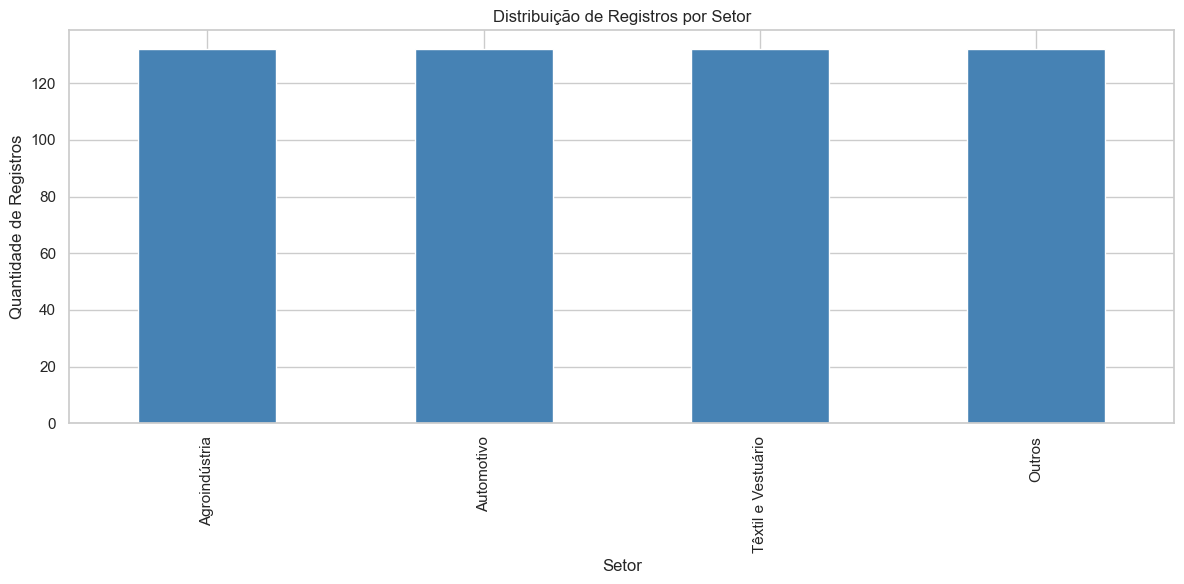

In [5]:

# Distribuição por setor
setor_counts = df_fato['id_Setor'].value_counts().rename(index=df_setores.set_index('id_Setor')['Setor'])
setor_counts.plot(kind='bar', color='steelblue', title='Distribuição de Registros por Setor')
plt.ylabel("Quantidade de Registros")
plt.xlabel("Setor")
plt.tight_layout()
plt.show()


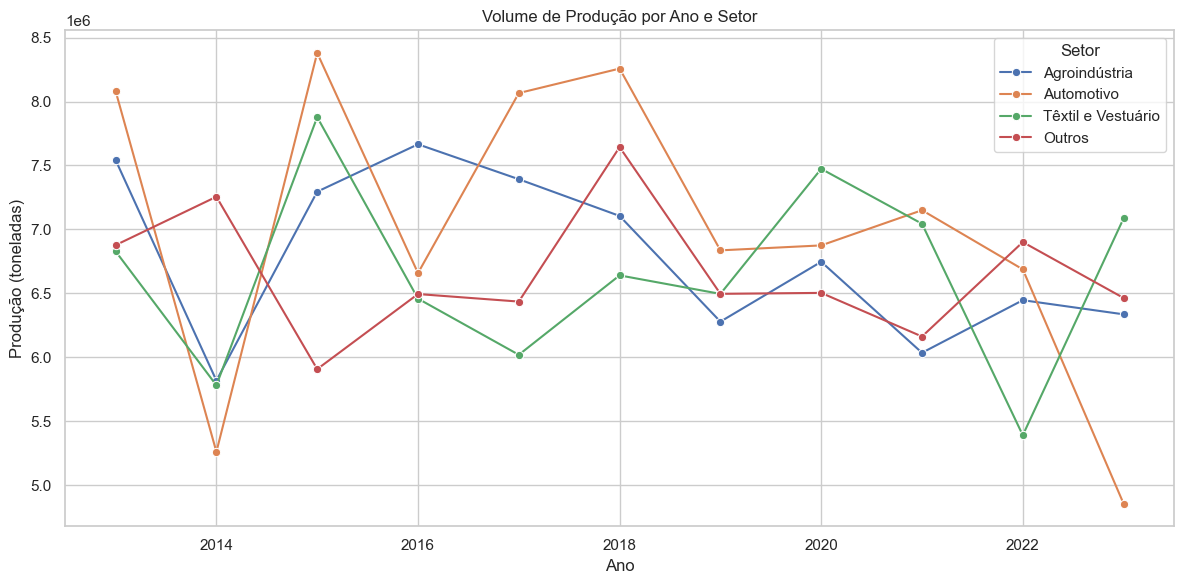

In [6]:

# Evolução da Produção ao longo dos anos
df_fato['Ano'] = df_fato['Data'].dt.year
df_agg = df_fato.groupby(['Ano', 'id_Setor'])['Volume de Produção (toneladas)'].sum().reset_index()
df_agg = df_agg.merge(df_setores, on='id_Setor')

sns.lineplot(data=df_agg, x='Ano', y='Volume de Produção (toneladas)', hue='Setor', marker='o')
plt.title('Volume de Produção por Ano e Setor')
plt.ylabel('Produção (toneladas)')
plt.xlabel('Ano')
plt.tight_layout()
plt.show()


## Correlação: Matéria-Prima vs Volume Produzido

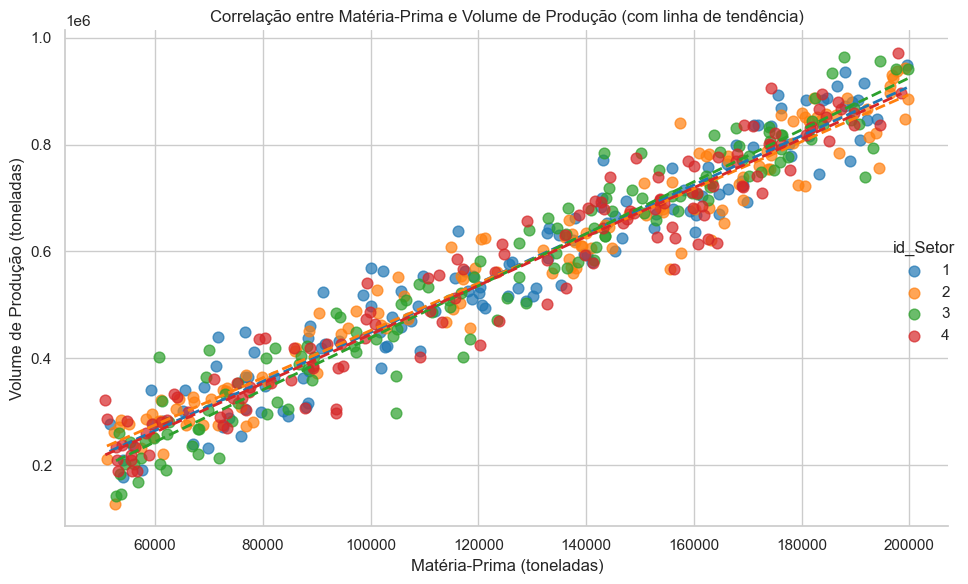

In [7]:

# Dispersão com linha de tendência
sns.lmplot(
    data=df_fato,
    x='Matéria-Prima (toneladas)',
    y='Volume de Produção (toneladas)',
    hue='id_Setor',
    palette='tab10',
    height=6,
    aspect=1.5,
    ci=None,
    scatter_kws={'s': 60, 'alpha': 0.7},
    line_kws={'lw': 2, 'linestyle': '--'}
)
plt.title("Correlação entre Matéria-Prima e Volume de Produção (com linha de tendência)")
plt.tight_layout()


## Tabela de Regressão Linear por Setor

In [8]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

resultados = []

for setor_id in df_fato['id_Setor'].unique():
    dados = df_fato[df_fato['id_Setor'] == setor_id]
    X = dados[['Matéria-Prima (toneladas)']]
    y = dados['Volume de Produção (toneladas)']

    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    r2 = r2_score(y, y_pred)

    resultados.append({
        'id_Setor': setor_id,
        'Inclinação (coef)': round(modelo.coef_[0], 2),
        'Intercepto': round(modelo.intercept_, 2),
        'R²': round(r2, 4)
    })

tabela_regressao = pd.DataFrame(resultados)
tabela_regressao = tabela_regressao.merge(df_setores[['id_Setor', 'Setor']], on='id_Setor')
tabela_regressao[['Setor', 'Inclinação (coef)', 'Intercepto', 'R²']]



,Setor,Inclinação (coef),Intercepto,R²
0,Agroindústria,4.60,-11272.55,0.9259
1,Automotivo,4.42,10209.36,0.9506
2,Têxtil e Vestuário,4.87,-48418.91,0.9436
3,Outros,4.58,-13036.13,0.9390



## Conclusão

A análise da regressão linear mostra que os dados simulados apresentam alta coerência entre matéria-prima e volume produzido, com coeficientes R² acima de 0.92 em todos os setores.

Esses resultados validam o modelo de geração sintética e asseguram que o painel e as visualizações baseadas nesses dados podem refletir relações plausíveis e informativas.

Este processo evidencia a importância de construir e validar dados simulados com estrutura lógica e estatística, especialmente ao criar produtos de portfólio voltados para análise de negócios.


